# Bid PDF Extraction - Analysis

Exploratory analysis of extracted data from construction bid PDFs.

In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
%matplotlib inline

## Load Extraction Results

In [18]:
# Load results
with open('../full_results.json', 'r') as f:
    data = json.load(f)

summary = data['summary']
results = data['results']

print(f"Total files processed: {summary['total_files']}")
print(f"Success rate: {summary['success_rate']}")

Total files processed: 100
Success rate: 96.0%


## Success Rate Analysis

In [19]:
# Document type distribution
doc_types = summary['by_document_type']
df_types = pd.DataFrame(doc_types).T

# Calculate success rate
df_types['success_rate'] = (df_types['successful'] / df_types['total'] * 100).round(1)

print(df_types)

                   total  successful  failed  success_rate
award_letter          28          28       0         100.0
bid_tabs              27          27       0         100.0
item_c_report         14          14       0         100.0
invitation_to_bid     27          27       0         100.0
bids_as_read           3           0       0           0.0
bid_summary            1           0       0           0.0


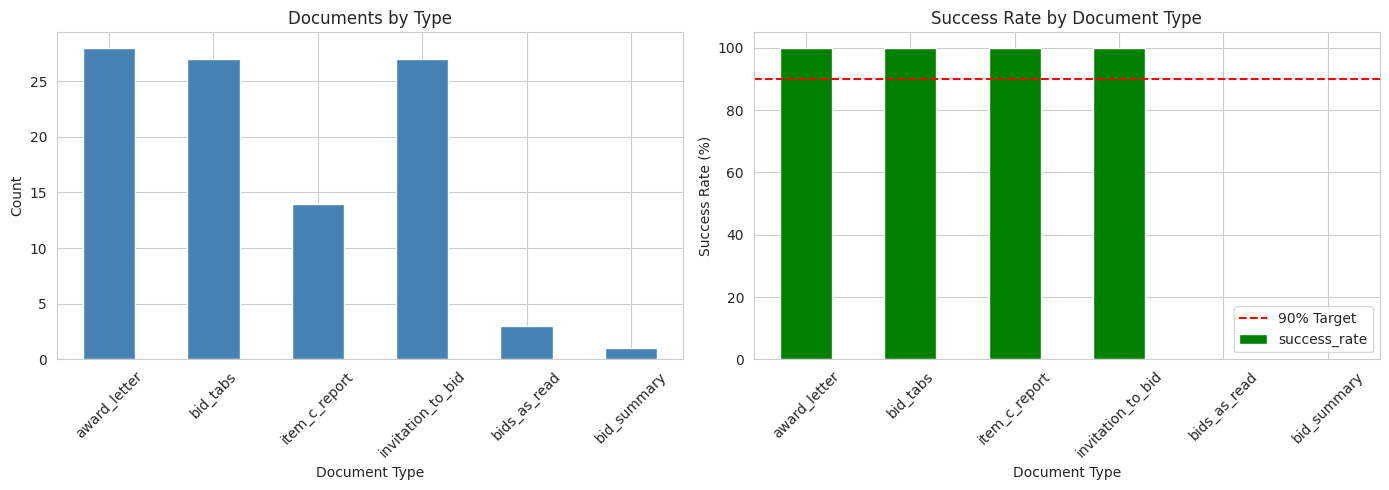

In [20]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Document type distribution
df_types['total'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Documents by Type')
axes[0].set_xlabel('Document Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Success rate by type
df_types['success_rate'].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Success Rate by Document Type')
axes[1].set_xlabel('Document Type')
axes[1].set_ylabel('Success Rate (%)')
axes[1].axhline(y=90, color='r', linestyle='--', label='90% Target')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Processing Time Analysis

In [21]:
# Extract processing times
processing_data = []
for result in results:
    if 'metadata' in result and 'processing_time' in result['metadata']:
        processing_data.append({
            'document_type': result.get('document_type', 'unknown'),
            'processing_time': result['metadata']['processing_time'],
            'status': result.get('status', 'unknown')
        })

df_performance = pd.DataFrame(processing_data)

print("\nProcessing Time Statistics:")
if df_performance.empty or 'document_type' not in df_performance.columns:
    print("No processing time data available to summarize.")
else:
    print(df_performance.groupby('document_type')['processing_time'].describe())


Processing Time Statistics:
                   count      mean       std       min       25%       50%  \
document_type                                                                
award_letter        28.0  0.028077  0.008894  0.021389  0.024086  0.025171   
bid_tabs            27.0  0.202671  0.166014  0.042754  0.072053  0.149194   
invitation_to_bid   27.0  0.049299  0.015951  0.023472  0.041639  0.046770   
item_c_report       14.0  0.009968  0.007645  0.003988  0.005018  0.007358   

                        75%       max  
document_type                          
award_letter       0.028153  0.058116  
bid_tabs           0.320772  0.515733  
invitation_to_bid  0.057210  0.085637  
item_c_report      0.012645  0.033217  


/home/andrepreira/.local/share/mise/installs/python/3.12.11/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


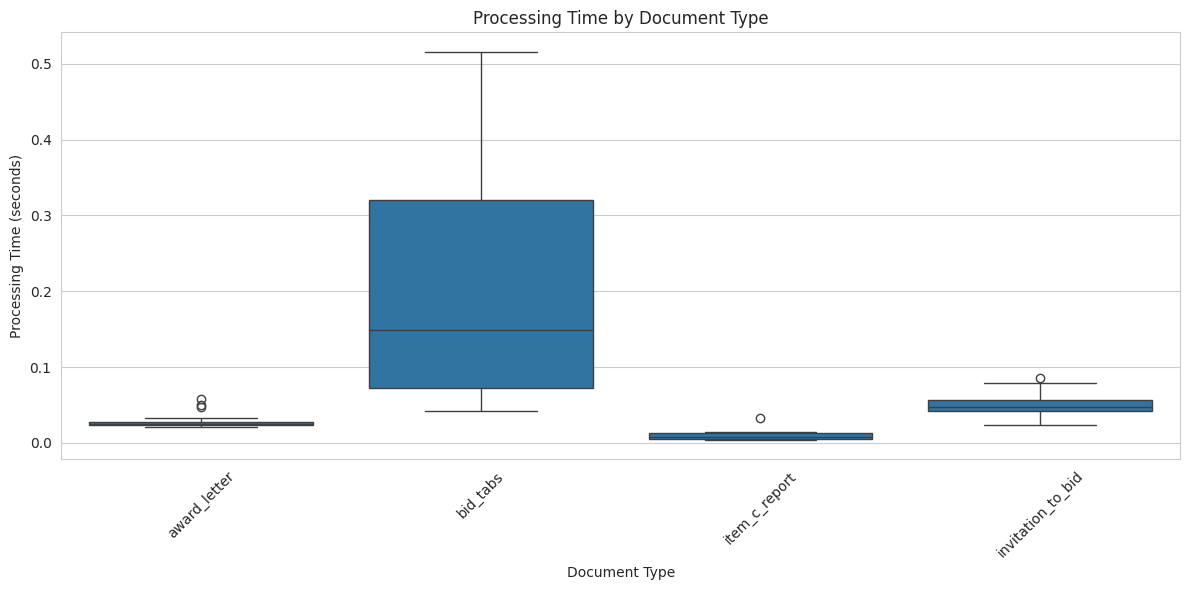

In [22]:
# Processing time distribution
if df_performance.empty or 'document_type' not in df_performance.columns:
    print("No processing time data available for plotting.")
else:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_performance, x='document_type', y='processing_time')
    plt.title('Processing Time by Document Type')
    plt.xlabel('Document Type')
    plt.ylabel('Processing Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Data Completeness Analysis

In [23]:
# Analyze data completeness
def calculate_completeness(data_dict):
    """Calculate percentage of non-null fields."""
    if not data_dict:
        return 0.0
    
    total = len(data_dict)
    filled = sum(1 for v in data_dict.values() if v is not None and v != "")
    return (filled / total * 100) if total > 0 else 0.0

completeness_data = []
for result in results:
    if result.get('status') == 'success' and 'data' in result:
        completeness = calculate_completeness(result['data'])
        completeness_data.append({
            'document_type': result.get('document_type', 'unknown'),
            'completeness': completeness,
            'file': Path(result['file_path']).name
        })

df_completeness = pd.DataFrame(completeness_data)

print("\nData Completeness by Document Type:")
print(df_completeness.groupby('document_type')['completeness'].describe())


Data Completeness by Document Type:
                   count        mean        std         min         25%  \
document_type                                                             
award_letter        28.0   87.755102  12.118267   57.142857   85.714286   
bid_tabs            27.0  100.000000   0.000000  100.000000  100.000000   
invitation_to_bid   27.0   31.851852  12.101188   10.000000   20.000000   
item_c_report       14.0   63.392857   3.340766   62.500000   62.500000   

                          50%    75%    max  
document_type                                
award_letter        85.714286  100.0  100.0  
bid_tabs           100.000000  100.0  100.0  
invitation_to_bid   30.000000   40.0   60.0  
item_c_report       62.500000   62.5   75.0  


/home/andrepreira/.local/share/mise/installs/python/3.12.11/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/andrepreira/.local/share/mise/installs/python/3.12.11/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/andrepreira/.local/share/mise/installs/python/3.12.11/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to sile

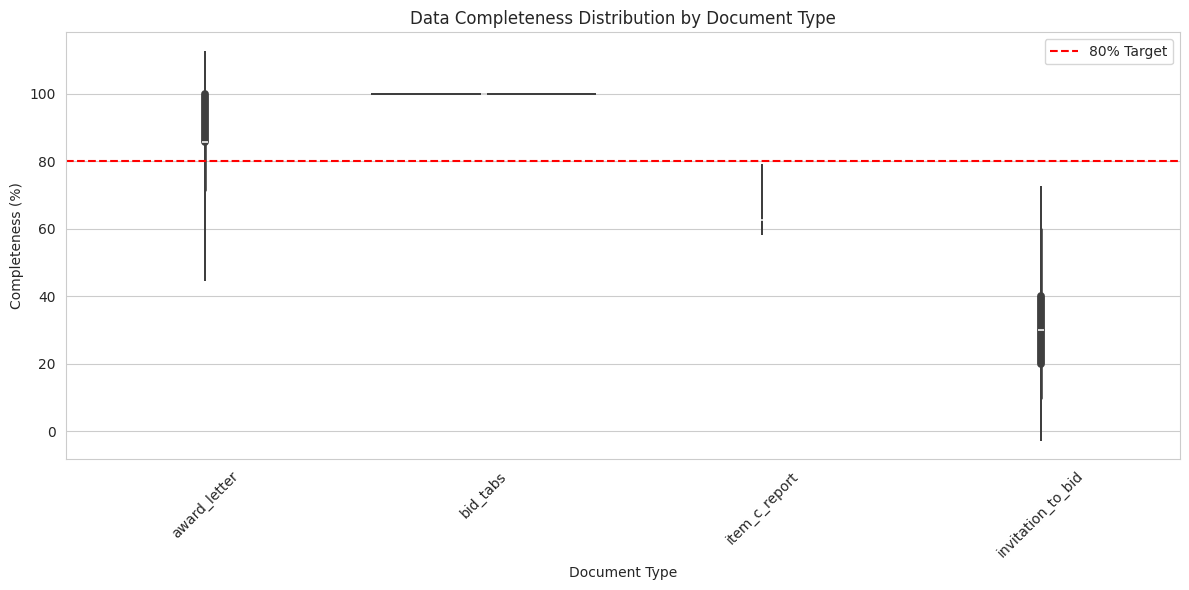

In [24]:
# Visualize completeness
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_completeness, x='document_type', y='completeness')
plt.title('Data Completeness Distribution by Document Type')
plt.xlabel('Document Type')
plt.ylabel('Completeness (%)')
plt.axhline(y=80, color='r', linestyle='--', label='80% Target')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Contract Data Analysis

In [25]:
# Extract contract data
contracts = []
for result in results:
    if result.get('status') == 'success' and 'data' in result:
        data = result['data']
        if result.get('document_type') in ['invitation_to_bid', 'award_letter', 'item_c_report']:
            contracts.append({
                'contract_number': data.get('contract_number'),
                'awarded_amount': data.get('awarded_amount'),
                'estimated_cost': data.get('estimated_cost'),
                'document_type': result.get('document_type')
            })

df_contracts = pd.DataFrame(contracts)
df_contracts = df_contracts.dropna(subset=['contract_number'])

print(f"\nTotal unique contracts: {df_contracts['contract_number'].nunique()}")
print(f"\nContracts with award amounts: {df_contracts['awarded_amount'].notna().sum()}")
print(f"Contracts with estimates: {df_contracts['estimated_cost'].notna().sum()}")


Total unique contracts: 25

Contracts with award amounts: 23
Contracts with estimates: 14


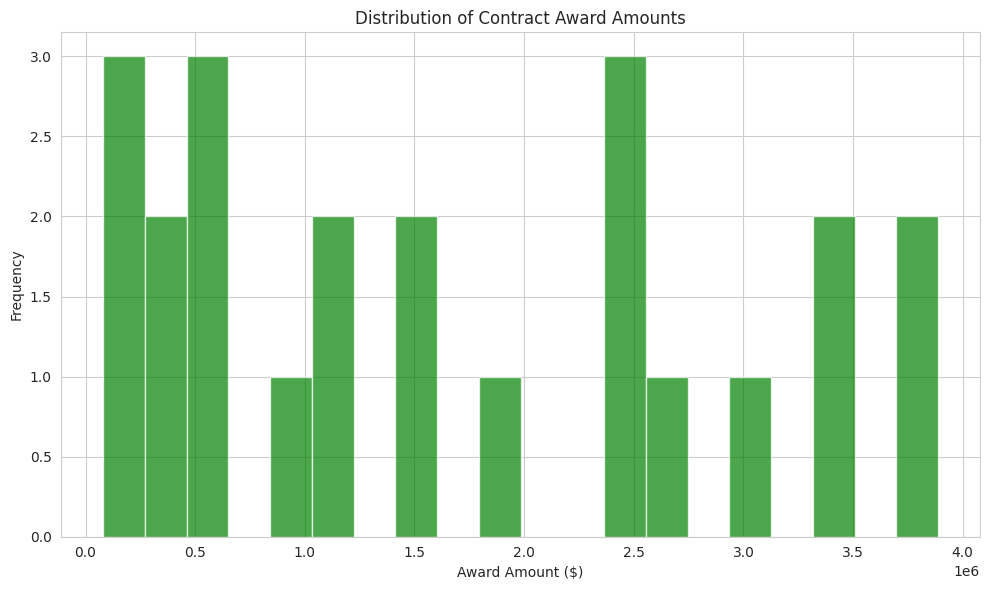


Award Amount Statistics:
Mean: $1,684,289.18
Median: $1,487,760.00
Min: $79,730.00
Max: $3,888,567.94


In [26]:
# Award amount distribution
awarded_contracts = df_contracts[df_contracts['awarded_amount'].notna()]

if len(awarded_contracts) > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(awarded_contracts['awarded_amount'], bins=20, color='green', alpha=0.7)
    plt.title('Distribution of Contract Award Amounts')
    plt.xlabel('Award Amount ($)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    print(f"\nAward Amount Statistics:")
    print(f"Mean: ${awarded_contracts['awarded_amount'].mean():,.2f}")
    print(f"Median: ${awarded_contracts['awarded_amount'].median():,.2f}")
    print(f"Min: ${awarded_contracts['awarded_amount'].min():,.2f}")
    print(f"Max: ${awarded_contracts['awarded_amount'].max():,.2f}")

## Key Findings

Summary of analysis will be displayed here after running all cells.